# Mouse Aging 10X RNA-seq clustering analysis and annotation

The Mouse Aging dataset [Jin et al] is a comprehensive single-cell RNA sequencing (scRNA-seq) dataset containing ~1.2 million high-quality single-cell transcriptomes of brain cells from young adult and aged mice of both sexes, from regions spanning the forebrain, midbrain, and hindbrain. High-resolution de novo clustering of all cells results in 847 cell clusters and reveals at least 12 age-biased clusters that are mostly glial types. Clusters in the study were mapped to the whole mouse brain taxonomy (WMB-taxonomy) to provided class, subclass and supertype annotations. At the broader cell subclass and supertype levels, age-associated gene expression signatures were analyzed resulting in a list of 2,449 differentially expressed genes (age-DE genes) for many neuronal and non-neuronal cell types.

The purpose of this set of notebooks is to provide an overview of the data, the file organization, and how to combine data and metadata through example use cases. 

You need to be connected to the internet to run this notebook or connected to a cache that has the Aging Mouse data downloaded already. 

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the ``general_acessing_10x_snRNASeq_tutorial.ipynb`` tutorial/example. 

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

pd.set_option('display.max_columns', 500)

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you have downloaded the data in your system.** 

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20241115/manifest.json'

## Data overview 

### Cell metadata 

Essential cell metadata is stored as a DataFrame. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. The *barcoded cell sample* label or name is unique in the database. 

Each cell is associated with a *library label*, *library method*, *donor label*, *donor sex*, dissection *region_of_interest_label*, the corresponding coarse *anatomical division label* and the *matrix_prefix* identifying which data package this cell is part of. 

Further, each cell is associated with a *cluster alias* representing which cluster this cell is a member of and (x, y) coordinates of the cells UMAP in [AGING MOUSE UMAP FIGURE]. 

Below, we load the first of the metadata used in this tutorial. This pattern of loading metadata is repeated throughout the tutorials.

In [71]:
abc_cache.list_metadata_files('Zeng-Aging-Mouse-10Xv3')

In [ ]:
abc_cache.list_metadata_files('Zeng-Aging-Mouse-taxonomy')

In [3]:
metadata_base = Path(
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/mouse_aging_prep/staging/"
    "metadata/Zeng-Aging-Mouse-10Xv3/20241130"
)
taxonomy_base = Path(
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/lydian/mouse_aging_prep/staging/"
    "metadata/Zeng-Aging-Mouse-WMB-taxonomy/20241130"
)

In [4]:
cell = pd.read_csv(metadata_base / 'cell_metadata.csv', dtype={'cell_label': str,
                                                               'wmb_cluster_alias': 'Int64'})
# cell = abc_cache.get_metadata_dataframe(
#    directory='WHB-10Xv3',
#     file_name='cell_metadata',
#     dtype={'cell_label': str,
#            'wmb_cluster_alias': 'Int64'}
# )
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))
cell.head()

Number of cells =  1162568


cell_barcode  gene_count  umi_count  \
cell_label                                                          
AAACCCAAGGCACGAT-140_A01  AAACCCAAGGCACGAT        7002      29262   
AAACCCATCAAATAGG-140_A01  AAACCCATCAAATAGG        6300      22838   
AAACCCATCTCATGGA-140_A01  AAACCCATCTCATGGA        7260      33630   
AAACGAAAGCATCTTG-140_A01  AAACGAAAGCATCTTG        3822      12370   
AAACGAAAGCTCCATA-140_A01  AAACGAAAGCTCCATA        6251      22389   

                          doublet_score          x         y  cluster_alias  \
cell_label                                                                    
AAACCCAAGGCACGAT-140_A01           0.29 -11.631238  5.529424            599   
AAACCCATCAAATAGG-140_A01           0.16  -4.561319  8.795810            425   
AAACCCATCTCATGGA-140_A01           0.15  -7.981854  9.037793            468   
AAACGAAAGCATCTTG-140_A01           0.04  13.590621  1.441468            817   
AAACGAAAGCTCCATA-140_A01           0.22  -5.970205  8.956449            421   

                          cell_in_wmb_study  wmb_cluster_alias  \
cell_label                                                       
AAACCCAAGGCACGAT-140_A01               True               3537   
AAACCCATCAAATAGG-140_A01               True               2353   
AAACCCATCTCATGGA-140_A01               True               4470   
AAACGAAAGCATCTTG-140_A01               True               5231   
AAACGAAAGCTCCATA-140_A01               True               2356   

                               library_label  alignment_job_id library_method  \
cell_label                                                                      
AAACCCAAGGCACGAT-140_A01  L8TX_190725_01_A09        1178165423          10Xv3   
AAACCCATCAAATAGG-140_A01  L8TX_190725_01_A09        1178165423          10Xv3   
AAACCCATCTCATGGA-140_A01  L8TX_190725_01_A09        1178165423          10Xv3   
AAACGAAAGCATCTTG-140_A01  L8TX_190725_01_A09        1178165423          10Xv3   
AAACGAAAGCTCCATA-140_A01  L8TX_190725_01_A09        1178165423          10Xv3   

                         barcoded_cell_sample_label  \
cell_label                                            
AAACCCAAGGCACGAT-140_A01                    140_A01   
AAACCCATCAAATAGG-140_A01                    140_A01   
AAACCCATCTCATGGA-140_A01                    140_A01   
AAACGAAAGCATCTTG-140_A01                    140_A01   
AAACGAAAGCTCCATA-140_A01                    140_A01   

                                enrichment_population  \
cell_label                                              
AAACCCAAGGCACGAT-140_A01  RFP-positive, DAPI-negative   
AAACCCATCAAATAGG-140_A01  RFP-positive, DAPI-negative   
AAACCCATCTCATGGA-140_A01  RFP-positive, DAPI-negative   
AAACGAAAGCATCTTG-140_A01  RFP-positive, DAPI-negative   
AAACGAAAGCTCCATA-140_A01  RFP-positive, DAPI-negative   

                         region_of_interest_label anatomical_division_label  \
cell_label                                                                    
AAACCCAAGGCACGAT-140_A01            MB - PAG-RAmb                        MB   
AAACCCATCAAATAGG-140_A01            MB - PAG-RAmb                        MB   
AAACCCATCTCATGGA-140_A01            MB - PAG-RAmb                        MB   
AAACGAAAGCATCTTG-140_A01            MB - PAG-RAmb                        MB   
AAACGAAAGCTCCATA-140_A01            MB - PAG-RAmb                        MB   

                          library_in_wmb_study                   donor_label  \
cell_label                                                                     
AAACCCAAGGCACGAT-140_A01                  True  Snap25-IRES2-Cre;Ai14-473981   
AAACCCATCAAATAGG-140_A01                  True  Snap25-IRES2-Cre;Ai14-473981   
AAACCCATCTCATGGA-140_A01                  True  Snap25-IRES2-Cre;Ai14-473981   
AAACGAAAGCATCTTG-140_A01                  True  Snap25-IRES2-Cre;Ai14-473981   
AAACGAAAGCTCCATA-140_A01                  True  Snap25-IRES2-Cre;Ai14-473981   

                         population_sampling  \
cell_label  

We can use pandas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [5]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))

In [6]:
print_column_info(cell)

Number of unique cell_barcode = 997261 
Number of unique gene_count = 9838 
Number of unique umi_count = 81631 
Number of unique doublet_score = 804 
Number of unique x = 1146865 
Number of unique y = 1146953 
Number of unique cluster_alias = 847 
Number of unique cell_in_wmb_study = 2 [False, True]
Number of unique wmb_cluster_alias = 2656 
Number of unique library_label = 284 
Number of unique alignment_job_id = 284 
Number of unique library_method = 2 ['10Xv3', '10xV3.1']
Number of unique barcoded_cell_sample_label = 284 
Number of unique enrichment_population = 6 ['Calcein-positive, Hoechst-positive', 'Hoechst-positive', 'No FACS', 'RFP-positive, Calcein-positive, Hoechst-positive', 'RFP-positive, DAPI-negative', 'RFP-positive, Hoechst-positive']
Number of unique region_of_interest_label = 16 ['HPF - ENT', 'HPF - HIP', 'HPF - PAR-POST-PRE-SUB-ProS', 'HY - HY', 'Iscortex  - ACA', 'Isocortex  - AI', 'Isocortex - PL-ILA-ORB', 'Isocortex - RSP', 'MB - PAG-RAmb', 'MB - VTA-SN', 'P - Pmo

#### Cell metadata colors 

Below we load a DataFrame containing name and color mappings pre-cell for donor sex, region of interest, and anatomical division. This DataFrame is indexed by cell the same as the above cell_metadata. This allows us to label the UMAP with the previously mentioned distinct labels. 

In [7]:
cell_colors = pd.read_csv(
    metadata_base / 'cell_annotation_colors.csv'
).set_index('cell_label')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )
cell_colors.head()

anatomical_division_color  anatomical_division_order  \
cell_label                                                                      
AAACCCAAGGCACGAT-140_A01                   #FF64FF                          5   
AAACCCATCAAATAGG-140_A01                   #FF64FF                          5   
AAACCCATCTCATGGA-140_A01                   #FF64FF                          5   
AAACGAAAGCATCTTG-140_A01                   #FF64FF                          5   
AAACGAAAGCTCCATA-140_A01                   #FF64FF                          5   

                         donor_age_category_color  donor_age_category_order  \
cell_label                                                                    
AAACCCAAGGCACGAT-140_A01                  #9ACA3C                         0   
AAACCCATCAAATAGG-140_A01                  #9ACA3C                         0   
AAACCCATCTCATGGA-140_A01                  #9ACA3C                         0   
AAACGAAAGCATCTTG-140_A01                  #9ACA3C                         0   
AAACGAAAGCTCCATA-140_A01                  #9ACA3C                         0   

                         donor_sex_color  donor_sex_order  \
cell_label                                                  
AAACCCAAGGCACGAT-140_A01         #735AA6                1   
AAACCCATCAAATAGG-140_A01         #735AA6                1   
AAACCCATCTCATGGA-140_A01         #735AA6                1   
AAACGAAAGCATCTTG-140_A01         #735AA6                1   
AAACGAAAGCTCCATA-140_A01         #735AA6                1   

                         region_of_interest_color  region_of_interest_order  
cell_label                                                                   
AAACCCAAGGCACGAT-140_A01                  #FF90FF                        12  
AAACCCATCAAATAGG-140_A01                  #FF90FF                        12  
AAACCCATCTCATGGA-140_A01                  #FF90FF                        12  
AAACGAAAGCATCTTG-140_A01                  #FF90FF                        12  
AAACGAAAGCTCCATA-140_A01                  #FF90FF                        12

We will merge these two dataframes to create one that contains both cell metadata and color information, ready to plot on a UMAP. We also shuffle the cell metadata to get a more representative plot in the UMAP. This is done as the default DataFrame is sorted cell_id which correlates with some of the metadata (e.g. age).

In [8]:
cell_extended = cell.join(cell_colors, rsuffix='_cl_colors')
cell_extended = cell_extended.sample(frac=1, random_state=12345)

### UMAP spatial embedding: Donor and anatomic information 

Now that we've merged the color information into the main cells data, we can plot the Uniform Manifold Approximation and Projection (UMAP) for all the cells in the dataset. The UMAP is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. The x, y columns of the cell metadata table represent the coordinate of all cells in the UMAP in Figure [GET NEW CITE] of the manuscript. 

We define a small helper function *plot umap* to visualize the cells on the UMAP. In this example will plot associated cell information colorized by dissection region of interest, neurotransmitter identity, sex, taxonomy level, age category, and age depletion/enrichment. 

In [9]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None, labels=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if cmap is not None:
        scatt = ax.scatter(xx, yy, c=val, s=0.5, marker='.', cmap=cmap)
    elif cc is not None:
        scatt = ax.scatter(xx, yy, c=cc, s=0.5, marker='.')

    if labels is not None:
        from matplotlib.patches import Rectangle
        unique_colors = cc.unique()
        rects = []
        for color in unique_colors:
            rects.append(Rectangle((0, 0), 1, 1, fc=color))

        legend = ax.legend(rects, labels, loc=0)
        # ax.add_artist(legend)

    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

Below we plot the UMAPS for each of anatomical division, dissection, sex, and age. 

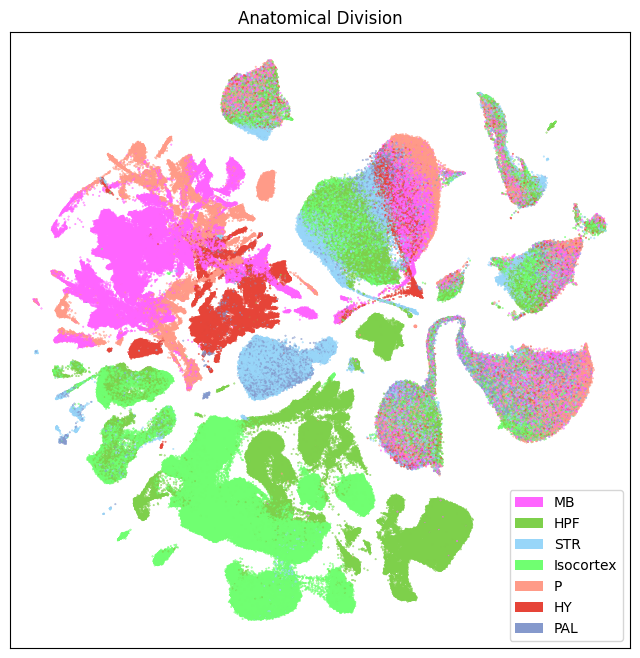

In [10]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['anatomical_division_color'],
    labels=cell_extended['anatomical_division_label'].unique()
)
res = ax.set_title("Anatomical Division")
plt.show()

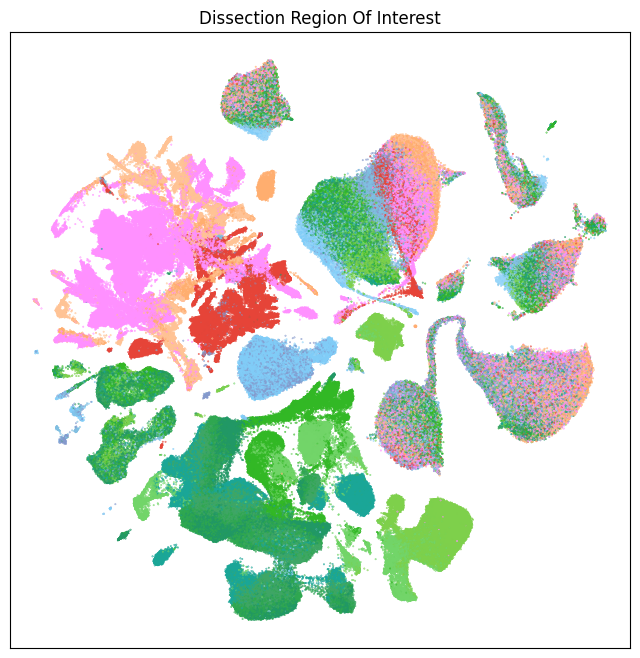

In [11]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['region_of_interest_color']
)
res = ax.set_title("Dissection Region Of Interest")
plt.show()

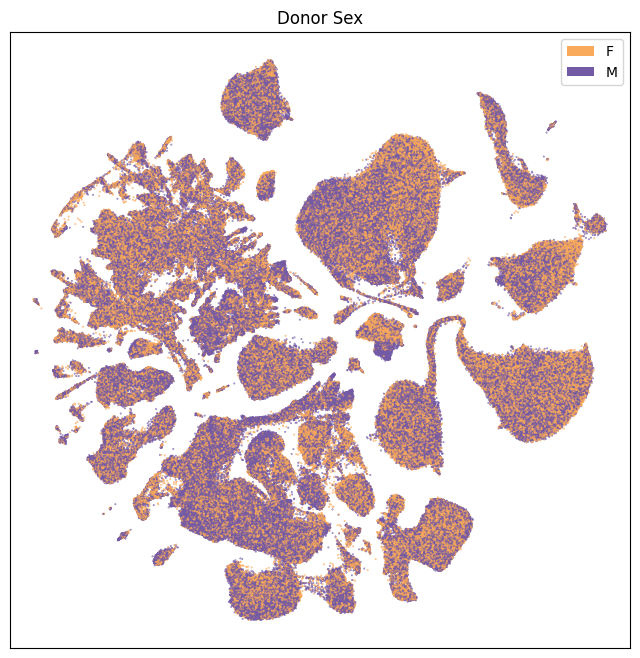

In [12]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['donor_sex_color'],
    labels=cell_extended['donor_sex'].unique()
)
res = ax.set_title("Donor Sex")
plt.show()

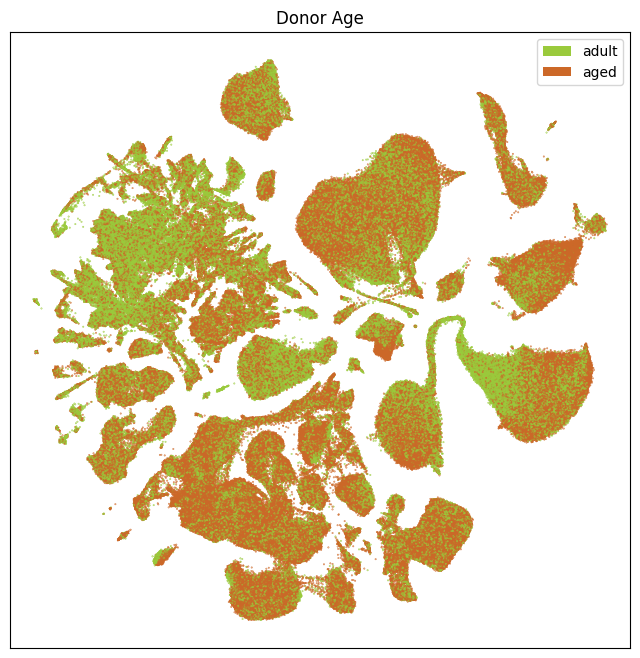

In [13]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['donor_age_category_color'],
    labels=cell_extended['donor_age_category'].unique()
)
res = ax.set_title("Donor Age")
plt.show()

##  Cluster Metadata

We load information on the individual clusters including the age ratio, odds, and neurotransmitter information. This metadata is indexed on cluster_alias which is also a column in the cell_metadata that allows us to merge the information into that DataFrame. 

In [14]:
cluster_info = pd.read_csv(
    metadata_base / 'cluster.csv'
).set_index('cluster_alias')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )
cluster_info

number_of_cells    cluster_label  cluster_order  \
cluster_alias                                                    
1                          851  CS20241021_0001              0   
2                          330  CS20241021_0002              1   
3                          589  CS20241021_0003              2   
4                          207  CS20241021_0004              3   
5                         2141  CS20241021_0005              4   
...                        ...              ...            ...   
843                       2640  CS20241021_0843            842   
844                        771  CS20241021_0844            843   
845                       3030  CS20241021_0845            844   
846                        248  CS20241021_0846            845   
847                        330  CS20241021_0847            846   

                            cluster_name cluster_color  number_of_adult_cells  \
cluster_alias                                                                   
1              1_CLA-EPd-CTX Car3 Glut_1       #f7c27a                    183   
2                     2_IT EP-CLA Glut_1       #5c1a34                    160   
3                     3_IT EP-CLA Glut_1       #b96cf0                    240   
4                     4_IT EP-CLA Glut_1       #bff691                    107   
5                     5_IT EP-CLA Glut_1       #39fbfa                    655   
...                                  ...           ...                    ...   
843                   843_Microglia NN_1       #a88b30                     71   
844                   844_Microglia NN_1       #df92c3                    284   
845                         845_BAM NN_1       #a1adea                   1462   
846                          846_DC NN_1       #9a5824                     98   
847                     847_T cells NN_4       #e7e085                     68   

               number_of_aged_cells  proportion_adult_cells  \
cluster_alias                                                 
1                               668                0.215041   
2                               170                0.484848   
3                               349                0.407470   
4                               100                0.516908   
5                              1486                0.305932   
...                             ...                     ...   
843                            2569                0.026894   
844                             487                0.368353   
845                            1568                0.482508   
846                             150                0.395161   
847                             262                0.206061   

               proportion_aged_cells  odds_ratio  log2_odds_ratio  \
cluster_alias                                                       
1                           0.784959    1.453797         0.539826   
2                           0.515152    0.421595        -1.246071   
3                           0.592530    0.576896        -0.793616   
4                           0.483092    0.371035        -1.430373   
5                           0.694068    0.900735        -0.150825   
...                              ...         ...              ...   
843                         0.973106   20.304439         4.343723   
844                         0.631647    0.911851        -0.133131   
845                         0.517492    0.556218        -0.846279   
846                         0.604839    0.814133        -0.296663   
847                         0.793939    2.056692         1.040326   

              cluster_age_bias cluster_age_bias_color  \
cluster_alias                                           
1                   unassigned                #DADEDF   
2                   unassigned                #DADEDF   
3                   unassigned                #DADEDF   
4                   unassigned                #DADEDF   
5                   unassigned            

Now that we have our data loaded and indexed, we can merge the tables together to create a single DataFrame allowing us to plot various information onto the UMAP and beyond. 

In [15]:
# Join the cluster information in by joining on the Aging dataset's cluster_alias column.
cell_extended = cell_extended.join(cluster_info, on='cluster_alias', rsuffix='_cl_info')

Finally, let's take a look at the coluns and unique data from our final dataframe.

### UMAP: Taxonomy information

Below are UMAPs for labels associated with the taxonomy, namely: neurotransmitter and cluster. Note that the colors for neurotransmitter (and for class, subclass, and supertype) are the same as those from the WMB taxonomy.

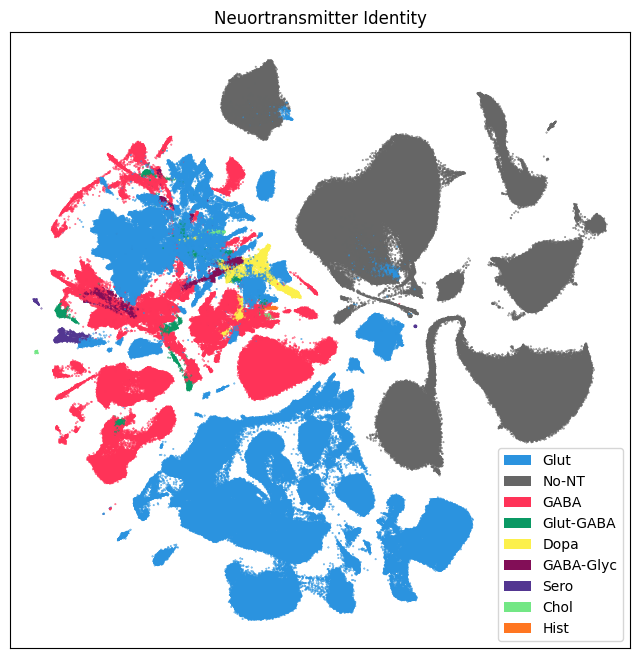

In [16]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['neurotransmitter_color'],
    labels=cell_extended['neurotransmitter_label'].unique()
)
res = ax.set_title("Neuortransmitter Identity")
plt.show()

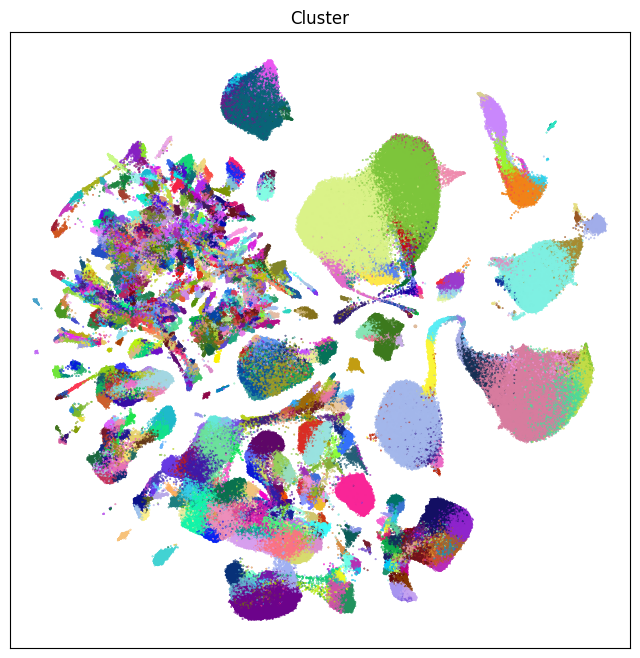

In [17]:
fig, ax = plot_umap(cell_extended['x'], cell_extended['y'], cc=cell_extended['cluster_color'])
res = ax.set_title("Cluster")
plt.show()

#### Aging information

We plot aging related information on our UMAP, showing the different age related variables and they are expressed in different locations of the UMAP. Below we show the location of the cells from the adult and aged mice.

Next we show the log of the cluster level odds ratio for a given cluster to be age enriched (brown) or depleted (blue-green).

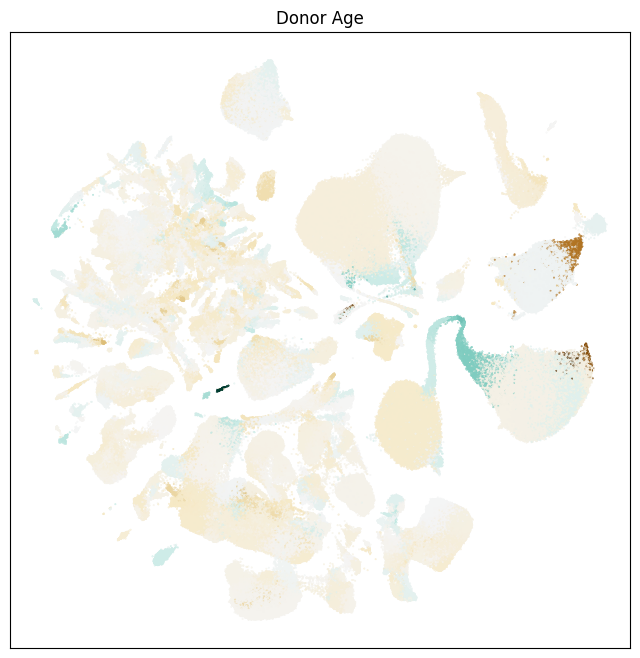

In [18]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    val=cell_extended['log2_odds_ratio'],
    cmap='BrBG_r'
)
res = ax.set_title("Donor Age")
plt.show()

Finally, how show the clusters that are identified as aging-enriched and aging-depleted based on their odds ratio. (-2.5 > log2_odds_ratio, log2_odds_ratio > 2.5).

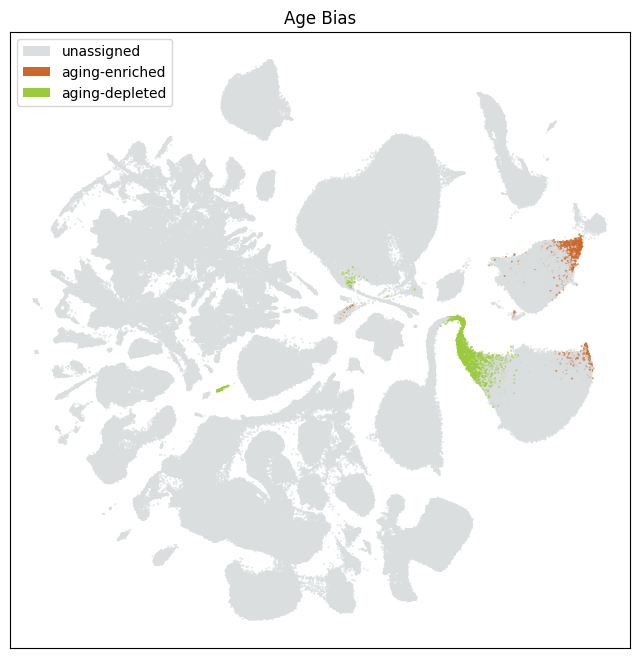

In [19]:
fig, ax = plot_umap(
    cell_extended['x'],
    cell_extended['y'],
    cc=cell_extended['cluster_age_bias_color'],
    labels=cell_extended['cluster_age_bias'].unique()
)
res = ax.set_title("Age Bias")
plt.show()

## Taxonomy Mapping

The following metadata maps all cells to the clusters and above levels in the taxonomy hierarchy. This includes all names and colors for each part of the taxonomy. As show in the above cluster tutorial for this dataset, each cluster in the Aging Dataset is nested within a supertype from the WMB dataset allowing one to walk all the way up to the class level.

In [20]:
cell_cluster_mapping = pd.read_csv(
    taxonomy_base / 'cell_cluster_mapping_annotations.csv'
).set_index('cell_label')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )
cell_cluster_mapping.head()

cluster_alias    cluster_label  cluster_order  \
cell_label                                                                
AAACCCAAGGCACGAT-140_A01            599  CS20241021_0599            598   
AAACCCATCAAATAGG-140_A01            425  CS20241021_0425            424   
AAACCCATCTCATGGA-140_A01            468  CS20241021_0468            467   
AAACGAAAGCATCTTG-140_A01            817  CS20241021_0817            816   
AAACGAAAGCTCCATA-140_A01            421  CS20241021_0421            420   

                                            cluster_name cluster_color  \
cell_label                                                               
AAACCCAAGGCACGAT-140_A01     599_SC-PAG Lef1 Emx2 Gaba_2       #6daa25   
AAACCCATCAAATAGG-140_A01  425_IF-RL-CLI-PAG Foxa1 Glut_4       #f1212a   
AAACCCATCTCATGGA-140_A01       468_PAG-MRN Tfap2b Glut_1       #7ae5a5   
AAACGAAAGCATCTTG-140_A01                    817_MOL NN_4       #d87c9f   
AAACGAAAGCTCCATA-140_A01  421_IF-RL-CLI-PAG Foxa1 Glut_2       #ea9fd7   

                            class_name                 subclass_name  \
cell_label                                                             
AAACCCAAGGCACGAT-140_A01    20 MB GABA     205 SC-PAG Lef1 Emx2 Gaba   
AAACCCATCAAATAGG-140_A01    19 MB Glut  159 IF-RL-CLI-PAG Foxa1 Glut   
AAACCCATCTCATGGA-140_A01    19 MB Glut       170 PAG-MRN Tfap2b Glut   
AAACGAAAGCATCTTG-140_A01  31 OPC-Oligo                  327 Oligo NN   
AAACGAAAGCTCCATA-140_A01    19 MB Glut  159 IF-RL-CLI-PAG Foxa1 Glut   

                                           supertype_name class_color  \
cell_label                                                              
AAACCCAAGGCACGAT-140_A01     0844 SC-PAG Lef1 Emx2 Gaba_2     #9EF01A   
AAACCCATCAAATAGG-140_A01  0688 IF-RL-CLI-PAG Foxa1 Glut_4     #007200   
AAACCCATCTCATGGA-140_A01       0733 PAG-MRN Tfap2b Glut_1     #007200   
AAACGAAAGCATCTTG-140_A01                    1184 MOL NN_4     #03045E   
AAACGAAAGCTCCATA-140_A01  0686 IF-RL-CLI-PAG Foxa1 Glut_2     #007200   

                         subclass_color supertype_color  
cell_label                                               
AAACCCAAGGCACGAT-140_A01        #4D79FF         #173A99  
AAACCCATCAAATAGG-140_A01        #63FF26         #CD99FF  
AAACCCATCTCATGGA-140_A01        #82995C         #2A1FCC  
AAACGAAAGCATCTTG-140_A01        #99FFBC         #99CAFF  
AAACGAAAGCTCCATA-140_A01        #63FF26         #99004E

In [21]:
cell_extended = cell_extended.join(cell_cluster_mapping, rsuffix='_cl_map')

# Quick run through to drop duplicated columns
drop_cols = []
for col in cell_extended.columns:
    if col.endswith(('_cl_map', '_cl_colors', '_cl_info')):
        drop_cols.append(col)
cell_extended.drop(columns=drop_cols, inplace=True)

Now that the information on the WMB taxonomy has been merged into our cell metadata, we plot them here. Note again that the colors here are the same as those in WMB.

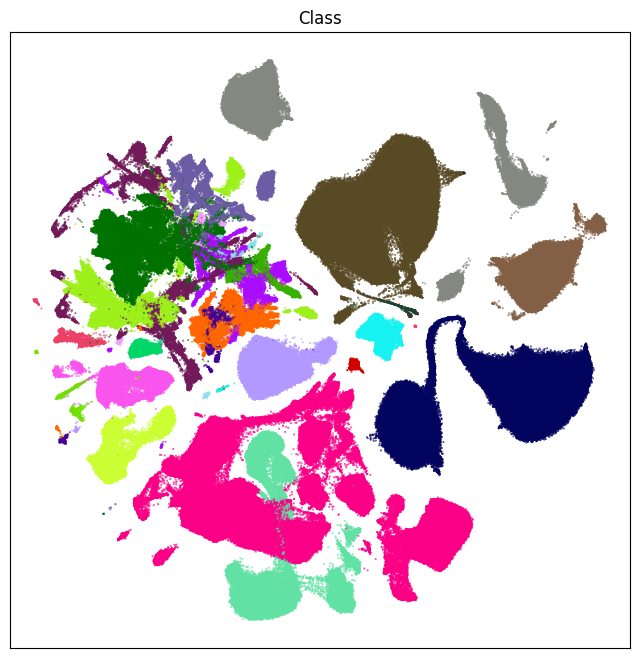

In [22]:
fig, ax = plot_umap(cell_extended['x'], cell_extended['y'], cc=cell_extended['class_color'])
res = ax.set_title("Class")
plt.show()

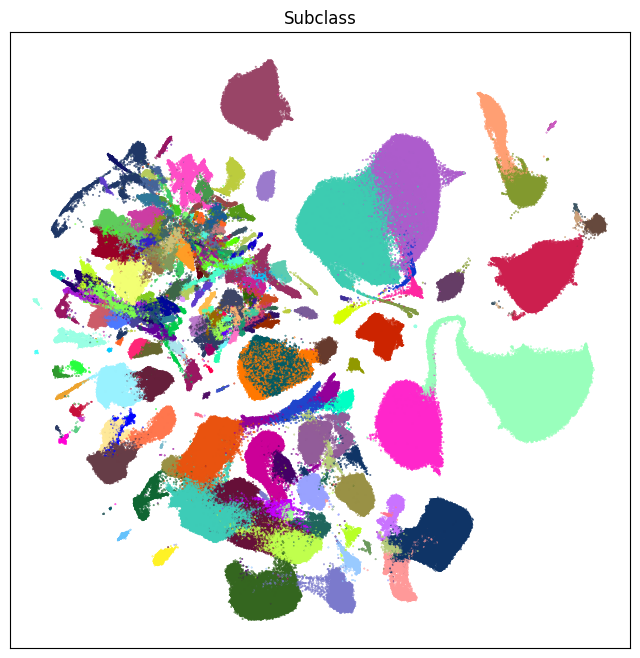

In [23]:
fig, ax = plot_umap(cell_extended['x'], cell_extended['y'], cc=cell_extended['subclass_color'])
res = ax.set_title("Subclass")
plt.show()

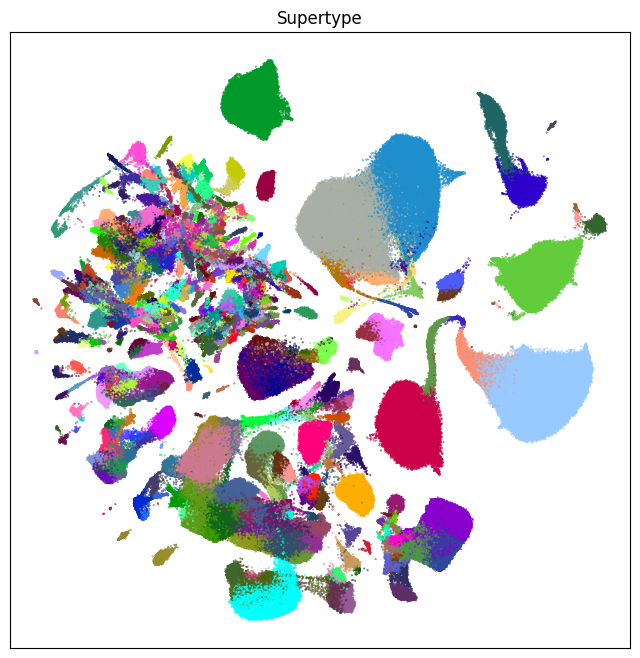

In [24]:
fig, ax = plot_umap(cell_extended['x'], cell_extended['y'], cc=cell_extended['supertype_color'])
res = ax.set_title("Supertype")
plt.show()

### Aggregating cluster and cells counts per term

Finally in this walkthrough of the data, we'll explore the taxonomy a bit more.

Now that we have information associated in each cluster and the full heirarchy of the taxonomy loaded, we can merge the cluster_info and cell mapping tables on their index (cluster_alias), producing a dataset describing the taxonomy. We'll use this to display counts of cells and clusters against various metadata.

We'll need to load one more metadata containing the full mapping of Aging Mouse cluster to the WMB taxonomy.

In [25]:
cluster_mapping = pd.read_csv(
    taxonomy_base / 'cluster_mapping.csv',
    dtype={'cluster_label': str}
).set_index('cluster_alias')
# mapping_annotations = abc_cache.get_metadata_dataframe(
#     directory='WHB-taxonomy',
#     file_name='cluster_to_cluster_annotation_membership'
# )
cluster_mapping.head()

cluster_label  cluster_order               cluster_name  \
cluster_alias                                                              
1              CS20241021_0001              0  1_CLA-EPd-CTX Car3 Glut_1   
2              CS20241021_0002              1         2_IT EP-CLA Glut_1   
3              CS20241021_0003              2         3_IT EP-CLA Glut_1   
4              CS20241021_0004              3         4_IT EP-CLA Glut_1   
5              CS20241021_0005              4         5_IT EP-CLA Glut_1   

              cluster_color cluster_annotation_term_label  \
cluster_alias                                               
1                   #f7c27a          CS20230722_SUPT_0001   
2                   #5c1a34          CS20230722_SUPT_0003   
3                   #b96cf0          CS20230722_SUPT_0003   
4                   #bff691          CS20230722_SUPT_0003   
5                   #39fbfa          CS20230722_SUPT_0003   

               cluster_annotation_term_name cluster_annotation_term_set_label  \
cluster_alias                                                                   
1              0001 CLA-EPd-CTX Car3 Glut_1                  CCN20230722_SUPT   
2                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
3                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
4                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
5                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   

                 parent_term_label parent_term_set_label  term_set_order  \
cluster_alias                                                              
1              CS20230722_SUBC_001      CCN20230722_SUBC               3   
2              CS20230722_SUBC_002      CCN20230722_SUBC               3   
3              CS20230722_SUBC_002      CCN20230722_SUBC               3   
4              CS20230722_SUBC_002      CCN20230722_SUBC               3   
5              CS20230722_SUBC_002      CCN20230722_SUBC               3   

               term_order cluster_annotation_term_set_name color_hex_triplet  
cluster_alias                                                                 
1                       0                        supertype           #99822E  
2                       2                        supertype           #994563  
3                       2                        supertype           #994563  
4                       2                        supertype           #994563  
5                       2                        supertype           #994563

Merge in cluster info to get the full set of colors and neurotransmitter identities.

In [26]:
membership = cluster_mapping.join(cluster_info, rsuffix='_cl_info')
membership.head()

cluster_label  cluster_order               cluster_name  \
cluster_alias                                                              
1              CS20241021_0001              0  1_CLA-EPd-CTX Car3 Glut_1   
2              CS20241021_0002              1         2_IT EP-CLA Glut_1   
3              CS20241021_0003              2         3_IT EP-CLA Glut_1   
4              CS20241021_0004              3         4_IT EP-CLA Glut_1   
5              CS20241021_0005              4         5_IT EP-CLA Glut_1   

              cluster_color cluster_annotation_term_label  \
cluster_alias                                               
1                   #f7c27a          CS20230722_SUPT_0001   
2                   #5c1a34          CS20230722_SUPT_0003   
3                   #b96cf0          CS20230722_SUPT_0003   
4                   #bff691          CS20230722_SUPT_0003   
5                   #39fbfa          CS20230722_SUPT_0003   

               cluster_annotation_term_name cluster_annotation_term_set_label  \
cluster_alias                                                                   
1              0001 CLA-EPd-CTX Car3 Glut_1                  CCN20230722_SUPT   
2                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
3                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
4                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   
5                     0003 IT EP-CLA Glut_1                  CCN20230722_SUPT   

                 parent_term_label parent_term_set_label  term_set_order  \
cluster_alias                                                              
1              CS20230722_SUBC_001      CCN20230722_SUBC               3   
2              CS20230722_SUBC_002      CCN20230722_SUBC               3   
3              CS20230722_SUBC_002      CCN20230722_SUBC               3   
4              CS20230722_SUBC_002      CCN20230722_SUBC               3   
5              CS20230722_SUBC_002      CCN20230722_SUBC               3   

               term_order cluster_annotation_term_set_name color_hex_triplet  \
cluster_alias                                                                  
1                       0                        supertype           #99822E   
2                       2                        supertype           #994563   
3                       2                        supertype           #994563   
4                       2                        supertype           #994563   
5                       2                        supertype           #994563   

               number_of_cells cluster_label_cl_info  cluster_order_cl_info  \
cluster_alias                                                                 
1                          851       CS20241021_0001                      0   
2                          330       CS20241021_0002                      1   
3                          589       CS20241021_0003                      2   
4                          207       CS20241021_0004                      3   
5                         2141       CS20241021_0005                      4   

                    cluster_name_cl_info cluster_color_cl_info  \
cluster_alias                                                    
1              1_CLA-EPd-CTX Car3 Glut_1               #f7c27a   
2                     2_IT EP-CLA Glut_1               #5c1a34   
3                     3_IT EP-CLA Glut_1               #b96cf0   
4                     4_IT EP-CLA Glut_1               #bff691   
5                     5_IT EP-CLA Glut_1               #39fbfa   

               number_of_adult_cells  number_of_aged_cells  \
cluster_alias                                                
1                                183                   668   
2                                160                   170   
3                                240                   349   
4                                107                   100   
5    

One final set of data to create is to calculate the number of clusters that are members of a given supertype, subclass, and class in the taxonomy.

In [27]:
# Count the number of clusters associated with each cluster annotation term
term_cluster_count = membership.groupby(['cluster_annotation_term_label'])[['cluster_label']].count()
term_cluster_count.columns = ['number_of_clusters']
term_cluster_count.head()

number_of_clusters
cluster_annotation_term_label                    
CS20230722_CLAS_01                            156
CS20230722_CLAS_02                             38
CS20230722_CLAS_03                              1
CS20230722_CLAS_04                              6
CS20230722_CLAS_05                              4

In [28]:
term_by_label = membership.set_index('cluster_annotation_term_label')
term_with_counts = term_by_label.join(term_cluster_count)
term_with_counts.head()

cluster_label  cluster_order  \
cluster_annotation_term_label                                   
CS20230722_SUPT_0001           CS20241021_0001              0   
CS20230722_SUPT_0003           CS20241021_0002              1   
CS20230722_SUPT_0003           CS20241021_0003              2   
CS20230722_SUPT_0003           CS20241021_0004              3   
CS20230722_SUPT_0003           CS20241021_0005              4   

                                            cluster_name cluster_color  \
cluster_annotation_term_label                                            
CS20230722_SUPT_0001           1_CLA-EPd-CTX Car3 Glut_1       #f7c27a   
CS20230722_SUPT_0003                  2_IT EP-CLA Glut_1       #5c1a34   
CS20230722_SUPT_0003                  3_IT EP-CLA Glut_1       #b96cf0   
CS20230722_SUPT_0003                  4_IT EP-CLA Glut_1       #bff691   
CS20230722_SUPT_0003                  5_IT EP-CLA Glut_1       #39fbfa   

                               cluster_annotation_term_name  \
cluster_annotation_term_label                                 
CS20230722_SUPT_0001           0001 CLA-EPd-CTX Car3 Glut_1   
CS20230722_SUPT_0003                  0003 IT EP-CLA Glut_1   
CS20230722_SUPT_0003                  0003 IT EP-CLA Glut_1   
CS20230722_SUPT_0003                  0003 IT EP-CLA Glut_1   
CS20230722_SUPT_0003                  0003 IT EP-CLA Glut_1   

                              cluster_annotation_term_set_label  \
cluster_annotation_term_label                                     
CS20230722_SUPT_0001                           CCN20230722_SUPT   
CS20230722_SUPT_0003                           CCN20230722_SUPT   
CS20230722_SUPT_0003                           CCN20230722_SUPT   
CS20230722_SUPT_0003                           CCN20230722_SUPT   
CS20230722_SUPT_0003                           CCN20230722_SUPT   

                                 parent_term_label parent_term_set_label  \
cluster_annotation_term_label                                              
CS20230722_SUPT_0001           CS20230722_SUBC_001      CCN20230722_SUBC   
CS20230722_SUPT_0003           CS20230722_SUBC_002      CCN20230722_SUBC   
CS20230722_SUPT_0003           CS20230722_SUBC_002      CCN20230722_SUBC   
CS20230722_SUPT_0003           CS20230722_SUBC_002      CCN20230722_SUBC   
CS20230722_SUPT_0003           CS20230722_SUBC_002      CCN20230722_SUBC   

                               term_set_order  term_order  \
cluster_annotation_term_label                               
CS20230722_SUPT_0001                        3           0   
CS20230722_SUPT_0003                        3           2   
CS20230722_SUPT_0003                        3           2   
CS20230722_SUPT_0003                        3           2   
CS20230722_SUPT_0003                        3           2   

                              cluster_annotation_term_set_name  \
cluster_annotation_term_label                                    
CS20230722_SUPT_0001                                 supertype   
CS20230722_SUPT_0003                                 supertype   
CS20230722_SUPT_0003                                 supertype   
CS20230722_SUPT_0003                                 supertype   
CS20230722_SUPT_0003                                 supertype   

                              color_hex_triplet  number_of_cells  \
cluster_annotation_term_label                                      
CS20230722_SUPT_0001                    #99822E              851   
CS20230722_SUPT_0003                    #994563              330   
CS20230722_SUPT_0003                    #994563              589   
CS20230722_SUPT_0003                    #994563              207   
CS20230722_SUPT_0003                    #994563             2141   

                              cluster_label_cl_info  cluster_order_cl_info  \
cluster_annotation_term_label                                                
CS20230722_SUPT_0001                CS20241021_0001                      0   
CS20230722_

Let's visualize cluster and cells counts for of the classification levels using bar plots.

In [29]:
def bar_plot_by_level_and_type(df, level=None, fig_width = 8.5, fig_height = 4):
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(fig_width, fig_height)
    
    for idx, ctype in enumerate(['clusters', 'cells']):

        if level.lower().startswith('neurotransmitter'):
            level = 'Neurotransmitter'
            names = df['neurotransmitter_label']
            pred = np.ones(len(df), dtype=bool)
            colors = df['neurotransmitter_color']
            counts = df['number_of_%s' % ctype]
        else:
            pred = (df['cluster_annotation_term_set_name'] == level)
            names = df[pred]['cluster_annotation_term_name']
            colors = df[pred]['color_hex_triplet']
            counts = df[pred]['number_of_%s' % ctype]
        
        ax[idx].barh(names, counts, color=colors)
        ax[idx].set_title('Number of %s by %s' % (ctype, level)),
        ax[idx].set_xscale('log')

        if idx > 0 :
            ax[idx].set_yticklabels([])

    plt.show()

#### Neurotransmitter cluster and  cell counts
As seen below, most of the clusters in the study are glutamatergic, while the majority of cells are Nonueronal.

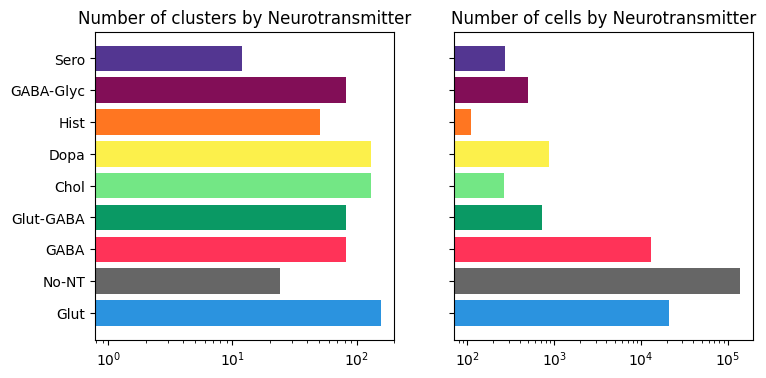

In [30]:
bar_plot_by_level_and_type(term_with_counts, 'neurotransmitter_label')

#### Class level cluster and cell counts
Class "01 IT-ET" contains the largest number of clusters (~100), while class "30 Astro-Epen" contains the largest number of cells.

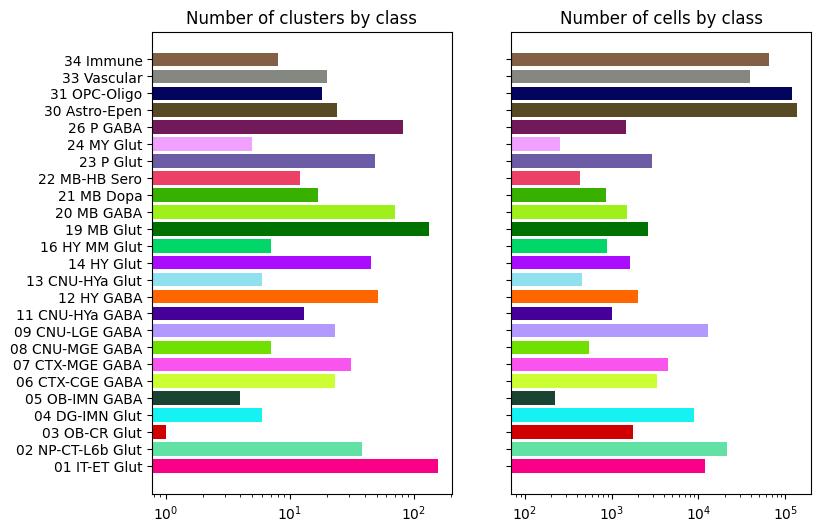

In [31]:
bar_plot_by_level_and_type(term_with_counts, 'class', 8.5, 6)

### Visualizing cluster and term distributions

We can explore the relationship and distribution of clusters between term sets by creating a pivot table using pandas groupby fuunction. Each row of the resulting dataframe represents a cluster, each column represents a term set and the value in the table is the name of the term that has been associated with the cluster for that specific term set.

In [32]:
pivot = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['cluster_annotation_term_name'].first().unstack()
pivot = pivot.join(cluster_info)
pivot

class                   subclass  \
cluster_alias                                             
1              01 IT-ET Glut  001 CLA-EPd-CTX Car3 Glut   
2              01 IT-ET Glut         002 IT EP-CLA Glut   
3              01 IT-ET Glut         002 IT EP-CLA Glut   
4              01 IT-ET Glut         002 IT EP-CLA Glut   
5              01 IT-ET Glut         002 IT EP-CLA Glut   
...                      ...                        ...   
843                34 Immune           334 Microglia NN   
844                34 Immune           334 Microglia NN   
845                34 Immune                 335 BAM NN   
846                34 Immune                  337 DC NN   
847                34 Immune            338 Lymphoid NN   

                                  supertype  number_of_cells    cluster_label  \
cluster_alias                                                                   
1              0001 CLA-EPd-CTX Car3 Glut_1              851  CS20241021_0001   
2                     0003 IT EP-CLA Glut_1              330  CS20241021_0002   
3                     0003 IT EP-CLA Glut_1              589  CS20241021_0003   
4                     0003 IT EP-CLA Glut_1              207  CS20241021_0004   
5                     0003 IT EP-CLA Glut_1             2141  CS20241021_0005   
...                                     ...              ...              ...   
843                     1194 Microglia NN_1             2640  CS20241021_0843   
844                     1194 Microglia NN_1              771  CS20241021_0844   
845                           1195 BAM NN_1             3030  CS20241021_0845   
846                            1197 DC NN_1              248  CS20241021_0846   
847                       1201 T cells NN_4              330  CS20241021_0847   

               cluster_order               cluster_name cluster_color  \
cluster_alias                                                           
1                          0  1_CLA-EPd-CTX Car3 Glut_1       #f7c27a   
2                          1         2_IT EP-CLA Glut_1       #5c1a34   
3                          2         3_IT EP-CLA Glut_1       #b96cf0   
4                          3         4_IT EP-CLA Glut_1       #bff691   
5                          4         5_IT EP-CLA Glut_1       #39fbfa   
...                      ...                        ...           ...   
843                      842         843_Microglia NN_1       #a88b30   
844                      843         844_Microglia NN_1       #df92c3   
845                      844               845_BAM NN_1       #a1adea   
846                      845                846_DC NN_1       #9a5824   
847                      846           847_T cells NN_4       #e7e085   

               number_of_adult_cells  number_of_aged_cells  \
cluster_alias                                                
1                                183                   668   
2                                160                   170   
3                                240                   349   
4                                107                   100   
5                                655                  1486   
...                              ...                   ...   
843                               71                  2569   
844                              284                   487   
845                             1462                  1568   
846                               98                   150   
847                               68                   262   

               proportion_adult_cells  proportion_aged_cells  odds_ratio  \
cluster_alias                                                              
1                            0.215041               0.784959    1.453797   
2                            0.484848               0.515152    0.421595   
3                            0.407470               0.592530    0.576896   
4                            0.516908               0.483092    

We can also obtain a cluster annotation color pivot table in the same way.

In [33]:
color = membership.groupby(['cluster_alias', 'cluster_annotation_term_set_name'])['color_hex_triplet'].first().unstack().fillna('#f9f9f9')
color.columns = ['%s_color' % x for x in color.columns]
color

class_color subclass_color supertype_color
cluster_alias                                           
1                 #FA0087        #64c2fc         #99822E
2                 #FA0087        #1F665D         #994563
3                 #FA0087        #1F665D         #994563
4                 #FA0087        #1F665D         #994563
5                 #FA0087        #1F665D         #994563
...                   ...            ...             ...
843               #825f45        #CC1F4E         #62CC3D
844               #825f45        #CC1F4E         #62CC3D
845               #825f45        #66493D         #32662E
846               #825f45        #CCA27A         #FF999F
847               #825f45        #3D5766         #995E2E

[847 rows x 3 columns]

In [34]:
pivot = pivot.join(color)

### Plotting distributions of clusters and cells by taxonomy level

For a given pair of term sets A and B, we compute a cluster count table where the rows are terms in term set A, columns are terms in term set B and the table values being the number of clusters that is shared between the terms. 

In [35]:
def distribution(A, B, B_color) :
    
    AxB = pivot.groupby([A, B])[['cluster_name']].count()
    AxB.columns = ['number_of_clusters']
    AxB = AxB.unstack().fillna(0)
    B_names = pivot[B].unique()
    B_colors = pd.Series(data=pivot[B_color].unique(), index=B_names)
    
    return AxB, B_names, B_colors

Function *stacked_bar_distribution* takes the results of *distribution* as input to create distribution stacked bar plot.


In [36]:
def stacked_bar_distribution(AxB, B_names, B_colors, fig_width = 6, fig_height = 6):
    """
    """

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    bottom = np.zeros(len(AxB))

    for i, col in enumerate(AxB.columns):
        ax.barh(AxB.index, AxB[col], left=bottom, label=col[1], color=B_colors.loc[col[1]])
        bottom += np.array(AxB[col])

    ax.set_title('Distribution of %s in each %s' % (AxB.columns.names[1], AxB.index.name))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
    return fig, ax

#### Distribution of neurotransmitter clusters in each class

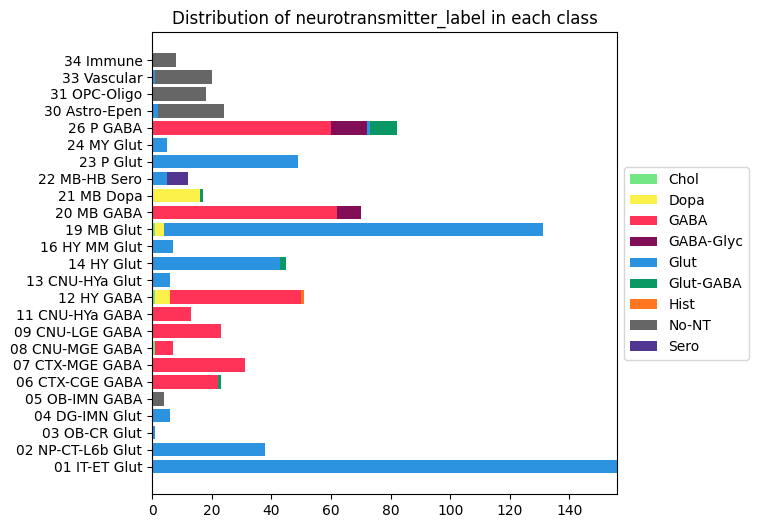

In [37]:
AxB, B_names, B_colors = distribution('class', 'neurotransmitter_label', 'neurotransmitter_color')
fig, ax = stacked_bar_distribution(AxB, B_names, B_colors, 6, 6)

#### Distribution of age enriched vs age depleted clusters

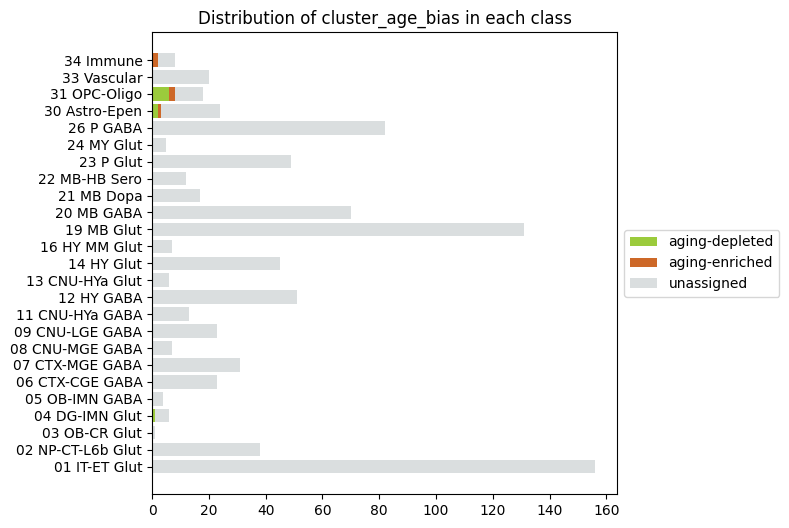

In [38]:
AxB, B_names, B_colors = distribution('class', 'cluster_age_bias', 'cluster_age_bias_color')
fig, ax = stacked_bar_distribution(AxB, B_names, B_colors, 6, 6)

#### Distribution of adult and aged cells

We can use the same groupby functionality as our distribution functions to this time sum up all the adult and age cells in each cluster and plot those versus class (or subclass, supertype).

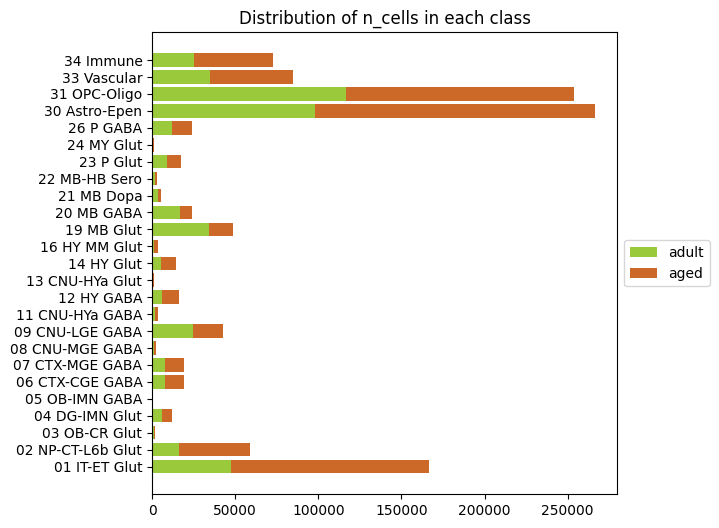

In [39]:
# Sum up the number of aged and adult cells.
n_adult = pivot.groupby(['class'])[['number_of_adult_cells']].sum()
n_aged = pivot.groupby(['class'])[['number_of_aged_cells']].sum()
adult_vs_aged = n_adult.join(n_aged)

# Rename columns and correctly label the aged/adult cells by color.
adult_vs_aged.columns = pd.MultiIndex.from_tuples(
    [('n_cells', 'adult'), ('n_cells', 'aged')],
    names=[None, 'n_cells'])
B_names = ['adult', 'aged']
B_colors = pd.Series(data=['#9ACA3C', '#CC6828'], index=B_names)

# Plot our barplot
fig, ax = stacked_bar_distribution(adult_vs_aged, B_names, B_colors, 6, 6)

### Visualizing the mouse whole brain taxonomy

Term sets: class, subclass, supertype and cluster forms a four level mouse whole brain taxonomy. We can visualized the taxonomy as a sunburst diagram that shows the single inheritance hierarchy through a series of rings, that are sliced for each annotation term. Each ring corresponds to a level in the hierarchy. We have ordered the rings so that the class level is the outer most ring so that we can add in labels. Rings are sliced up and divided based on their hierarchical relationship to the parent slice. The angle of each slice is proportional to the number of clusters belonging to the term.

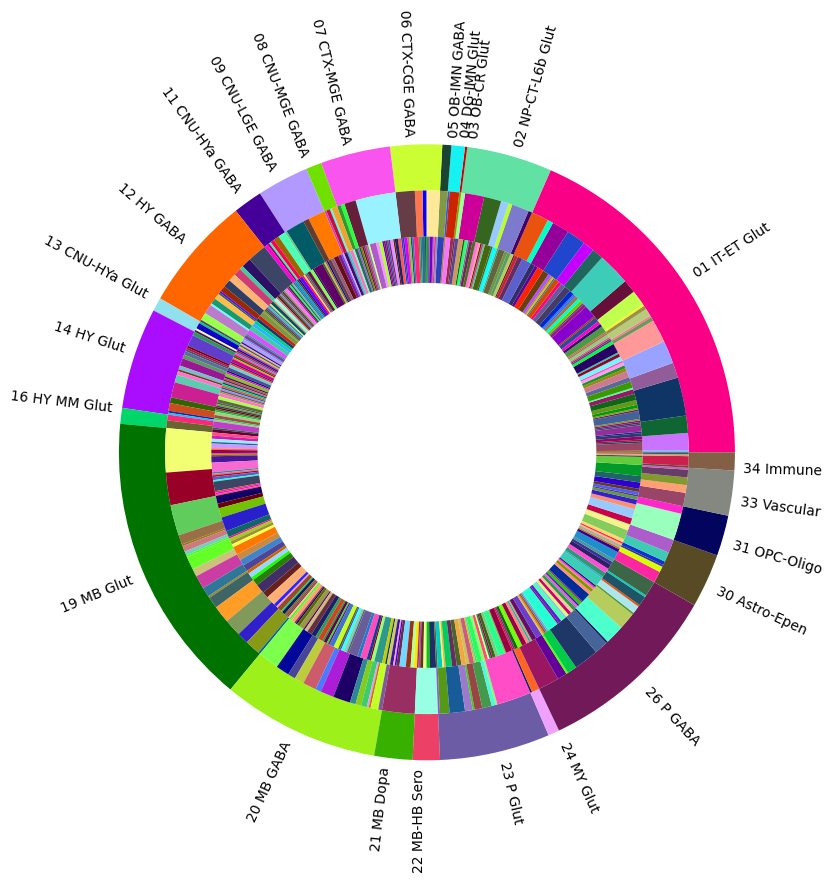

In [40]:
levels = ['class', 'subclass', 'supertype']
df = {}

for lvl in levels:
    pred = term_with_counts['cluster_annotation_term_set_name'] == lvl
    df[lvl] = term_with_counts[pred]
    df[lvl] = df[lvl].sort_values(['parent_term_label'])
    df[lvl] = df[lvl][~df[lvl].index.duplicated(keep='first')]

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
size = 0.15

for i, lvl in enumerate(levels):
    
    if lvl == 'class':
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               labels=df[lvl]['cluster_annotation_term_name'],
               rotatelabels=True,
               labeldistance=1.025,
               radius=1,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)
    else:
        ax.pie(df[lvl]['number_of_clusters'],
               colors=df[lvl]['color_hex_triplet'],
               radius=1-i*size,
               wedgeprops=dict(width=size, edgecolor=None),
               startangle=0)

plt.show()

**In part 2 we'll focus on gene data including using the UMAP to plot gene expression locations as well as age Differential (ageDE) genes identified in Zeng et al.**